**XGBoost for feature selection → SVM for classification**


# Libraries

In [10]:
# !pip install alibi

In [11]:
!pip install pdpbox

In [12]:
!pip install lofo-importance

In [13]:
!pip install lime

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,learning_curve
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from pdpbox import pdp
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from lofo import LOFOImportance, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import lime
import lime.lime_tabular
from lofo import LOFOImportance, Dataset, plot_importance
import shap

# Load & Split Dataset

In [15]:
df = pd.read_csv("/content/df_cleaned.csv")
df

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119281,36,1.072123,0.066746,-0.629220,-0.261895,0.822982,-0.473196,-0.461473,-0.593052,-0.629167,...,-0.461004,-0.445598,0,0,0.353569,0.720736,-0.931916,0.111700,4.179963,1
119282,26,0.475587,-0.417190,-0.629220,-0.261895,-1.462808,1.079697,0.555059,1.491599,-0.629167,...,0.555735,-0.445598,0,0,-0.727944,0.405263,-0.997673,2.309628,1.390440,0
119283,27,-0.983894,-0.414521,0.132695,-0.261895,1.003439,-0.951061,-1.078993,-0.949884,0.132868,...,-1.078649,-0.445598,0,0,2.336344,-0.109001,0.109992,-0.746028,-1.426978,1
119284,13,0.639197,-0.321768,-0.629220,3.433568,-0.981589,0.636417,1.311917,2.824325,-0.629167,...,1.312745,-0.445598,1,0,-0.259288,-0.484975,-0.158705,-0.049124,0.001258,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119286 entries, 0 to 119285
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_pymnt_d          119286 non-null  int64  
 1   total_rec_prncp       119286 non-null  float64
 2   last_pymnt_amnt       119286 non-null  float64
 3   out_prncp             119286 non-null  float64
 4   total_rec_late_fee    119286 non-null  float64
 5   last_fico_range_high  119286 non-null  float64
 6   installment           119286 non-null  float64
 7   loan_amnt             119286 non-null  float64
 8   total_rec_int         119286 non-null  float64
 9   out_prncp_inv         119286 non-null  float64
 10  total_pymnt           119286 non-null  float64
 11  funded_amnt_inv       119286 non-null  float64
 12  recoveries            119286 non-null  float64
 13  debt_settlement_flag  119286 non-null  int64  
 14  hardship_flag         119286 non-null  int64  
 15  

In [17]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [18]:
# scale features for SVM
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#  Feature Selection with XGBoost

In [20]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [21]:
# Get feature importances
importances = pd.Series(xgb.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(5).index

In [22]:
print("Top Features Selected by XGBoost:\n", top_features.tolist())

Top Features Selected by XGBoost:
 ['last_fico_range_high', 'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'out_prncp']


# Train SVM on selected features

In [23]:
svm = SVC(kernel='rbf', random_state=42, probability=True)
svm.fit(X_train[top_features], y_train)

SVC(probability=True, random_state=42)

# Evaluate SVM

In [24]:
y_pred = svm.predict(X_test[top_features])
y_prob = svm.predict_proba(X_test[top_features])[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     17285
           1       0.95      0.96      0.96     18501

    accuracy                           0.95     35786
   macro avg       0.95      0.95      0.95     35786
weighted avg       0.95      0.95      0.95     35786

ROC AUC Score: 0.9858361610893858


# Interpretability

## Learning Curve

In [25]:
def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

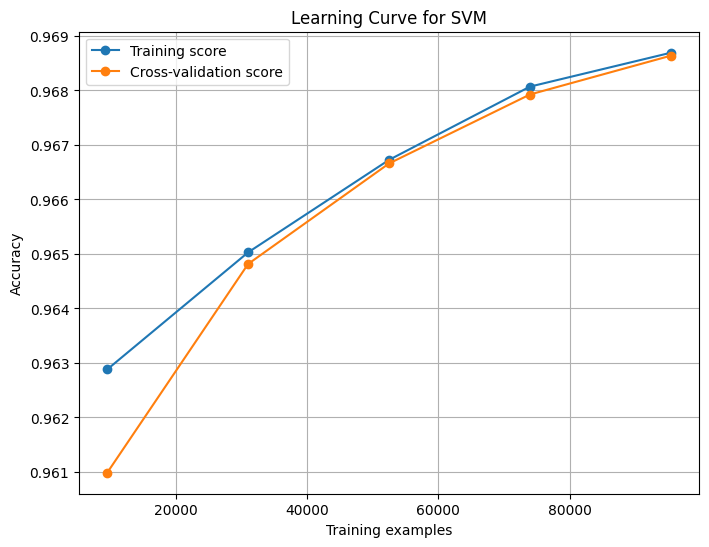

In [26]:
plot_learning_curve(svm, X, y, title='Learning Curve for SVM')

This learning curve for the SVM model shows a very good fit with minimal overfitting, and overall high model performance.

## Global Model-Agnostic

### ICE + PDP

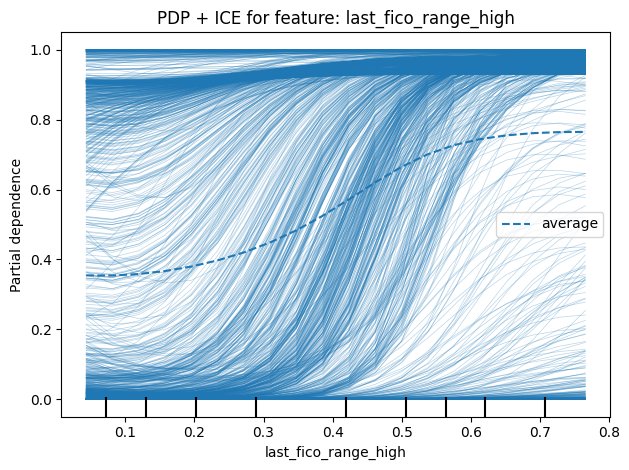

In [27]:
features = [top_features[0]]

PartialDependenceDisplay.from_estimator(
    estimator=svm,
    X=X_test[top_features],
    features=features,
    target=1,                     # for class 1 (positive class)
    kind='both',                 # show both ICE lines and PDP average
    subsample=1500,               # optional: limit for speed
    grid_resolution=20,          # smoother curve
    random_state=42
)

plt.title(f'PDP + ICE for feature: {features[0]}')
plt.tight_layout()
plt.show()

PDP
* The average line is rising:
* ➔ As last_fico_range_high increases, the model's predicted probability increases.

---


ICE
* The ICE lines show different patterns for different samples:

1. Some rise steeply,

2. Some are flat,

3. A few stay high or low throughout.

* ➔ The effect is not identical across all samples—for some individuals, last_fico_range_high has a strong impact, while for others it barely changes the prediction.

### LOFO

  0%|          | 0/5 [00:00<?, ?it/s]

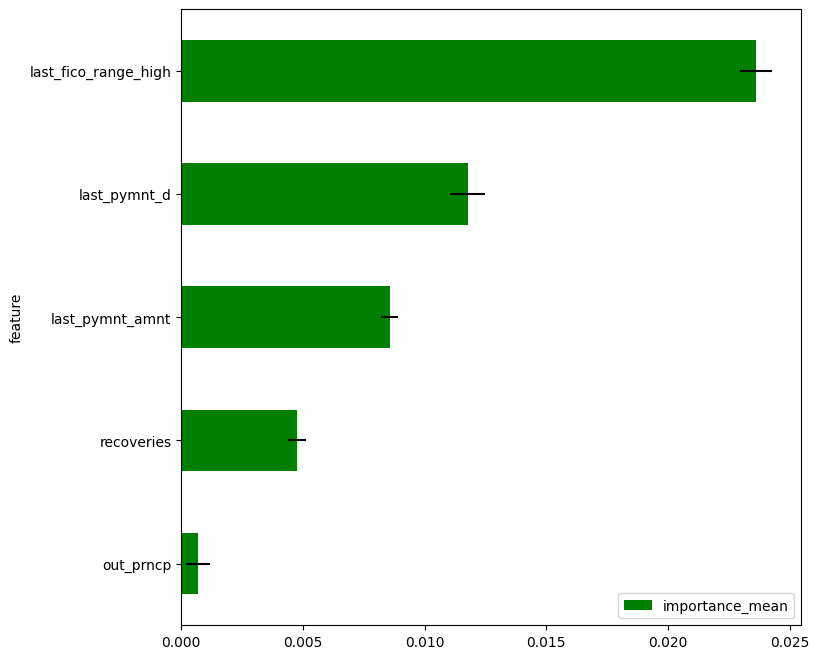

In [28]:
# Combine X_train and y_train
lofo_df = X_train[top_features].copy()
lofo_df['target'] = y_train.values  # Ensure alignment

# Create LOFO dataset
lofo_dataset = Dataset(df=lofo_df, target='target', features=top_features.tolist())

# Initialize and compute LOFO
lofo = LOFOImportance(
    lofo_dataset,
    model=svm,
    scoring='roc_auc'
)

importance_df = lofo.get_importance()
plot_importance(importance_df)

last_fico_range_high ➔ Highest bar (~0.024)
* ➔ Most critical feature ➔ Leaving this out causes the largest performance drop.

### PFI

last_fico_range_high 0.142 +/- 0.002
recoveries           0.100 +/- 0.001
last_pymnt_d         0.067 +/- 0.001
last_pymnt_amnt      0.042 +/- 0.001
out_prncp            0.020 +/- 0.001


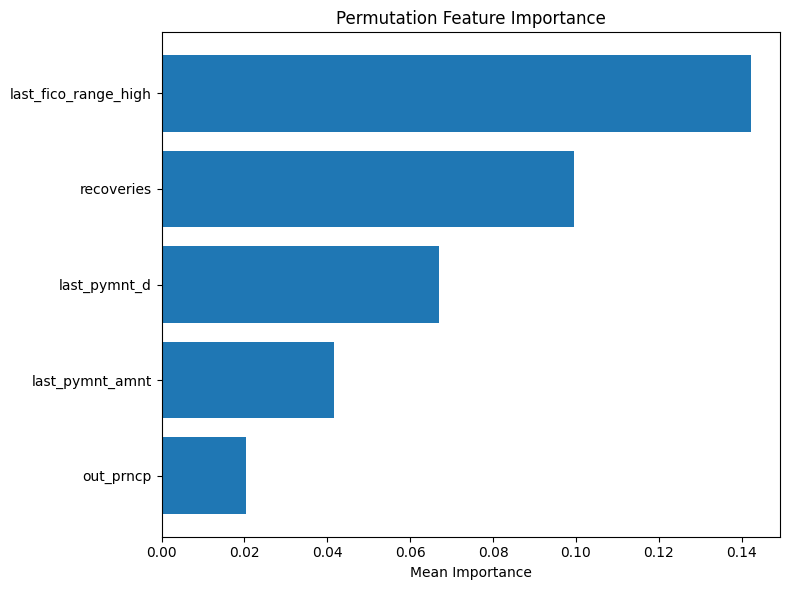

In [29]:
result = permutation_importance(
    estimator=svm,
    X=X_test[top_features],
    y=y_test,
    n_repeats=10,
    random_state=0
)

# Print sorted importances with uncertainty check
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{X_test[top_features].columns[i]:<20} "
              f"{result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(
    X_test[top_features].columns[sorted_idx],
    result.importances_mean[sorted_idx]
)
plt.xlabel("Mean Importance")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

Most important feature:

* last_fico_range_high ➔ Highest bar (~0.14).
* This tells us that shuffling this feature hurts model performance the most.

## Local Model-Agnostic

### LIME

In [31]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train[top_features].values,
    feature_names=top_features,
    class_names=["Class 0", "Class 1"],
    mode='classification'
)

i = 0
exp = explainer.explain_instance(
    X_test[top_features].iloc[i].values,
    svm.predict_proba,
    num_features=10
)
exp.show_in_notebook(show_table=True)

* The model strongly predicts Class 1 (97% confidence).
* Pushing Toward Class 1:
1. recoveries <= 0.00 → +0.35
2. last_fico_range_high > 0.64 → +0.33
3. last_pymnt_amnt > 0.04 → +0.27
* Pushing Toward Class 0:
1. last_pymnt_d > 0.69 → -0.08
2. out_prncp <= 0.00 → -0.04